# Chap 6. Linear Model Selection and Regularization

The objective is to predict hitters salary given various variables. 

In [184]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge #Linear Model trained with L2 prior as regularizer (ask the Ridge)
from sklearn.linear_model import Lasso #Linear Model trained with L1 prior as regularizer (aka the Lasso)
from sklearn.metrics import mean_squared_error #### 


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data exploration

### Get, check and clean the data

In [92]:
hitters_df = pd.read_csv("./data/Hitters.csv")

In [93]:
print hitters_df.shape

(322, 20)


Remove `nan` or strange symbol if there is any

In [94]:
# check and remove nan
hitters_df.isnull().values.any() # true
sum(hitters_df.isnull().values)
hitters_df.dropna(inplace = True)
hitters_df.shape

(263, 20)

In [95]:
hitters_df.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500,N


In [97]:
#Make a copy of the dataframe
df = hitters_df

### Feature engineering

In [99]:
# check dtypes
df.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

Now, an **indicator variable** is one which takes a few, usually 2 values (1/0, True/False) to code the existence or lack thereof of a property or feature. <font color="red">This is a regression problem, categorical variables need to be converted to numeric variables</font>

In [100]:
# convert categorical variables into numeric since this is a regression problem
df["League"], league_coding = pd.factorize(df["League"])
df["Division"], division_coding = pd.factorize(df["Division"])
df["NewLeague"], newleague_coding = pd.factorize(df["NewLeague"])


In [101]:
print league_coding
print division_coding
print newleague_coding

Index([u'N', u'A'], dtype='object')
Index([u'W', u'E'], dtype='object')
Index([u'N', u'A'], dtype='object')


We also list the columns with floating-point or integer variables that are amenable to **standardization**

In [123]:
STANDARDIZABLE = df.columns.drop(["League","Division","NewLeague","Salary"]) # Salary is the response
STANDARDIZABLE

Index([u'AtBat', u'Hits', u'HmRun', u'Runs', u'RBI', u'Walks', u'Years',
       u'CAtBat', u'CHits', u'CHmRun', u'CRuns', u'CRBI', u'CWalks',
       u'PutOuts', u'Assists', u'Errors'],
      dtype='object')

Other feature engineering methods including:     

1. encode continuous variables to categorical variables if the exact number is less important 
2. Combine some features
3. transform the data using log or square ??

In [124]:
hitters_df.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500,0


### Split original data into training and test sets

Use `Mask` to preserve the dataframe. If not, such as the following method, we will lose dataframe strucutre when converting it to numpy array.

In [81]:
# Split arrays or matrices into random train and test subsets
# easy, but lose the dataframe strucutre
X = df.drop(["Salary"], axis = 1).values
y = df.Salary.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Rather than getting numpy array from `train_test_split`, we can get index for future use.

In [106]:
# better method
itrain, itest = train_test_split(xrange(df.shape[0]), train_size = 0.7)

In [115]:
# create mask
mask = np.ones(df.shape[0])
mask[itrain] = 1
mask[itest] = 0
mask = (mask == 1)

mask.shape, mask.sum()

((263,), 184)

### Standardize the data

Use `StandardScaler` from `sklearn.preprocessing` to transform the columns in STANDRARDIZABLE on the **training set** to standardize the data with mean 0 and variance 1. Then use the resultant estimator to transform **both the training and the test parts** of each of the columns in the dataframe, replacing the old unstandardized values in the STANDARDIZABLE columns of df by the new standardized ones.


In [125]:
STANDARDIZABLE

Index([u'AtBat', u'Hits', u'HmRun', u'Runs', u'RBI', u'Walks', u'Years',
       u'CAtBat', u'CHits', u'CHmRun', u'CRuns', u'CRBI', u'CWalks',
       u'PutOuts', u'Assists', u'Errors'],
      dtype='object')

In [130]:
# standardize one column at a time, easy to put it back to the original df this way
for col in STANDARDIZABLE:
    in_train = df[col][mask]
    in_test = df[col][~mask]
    
    #apple scaler to the training and test sets
    scaler = StandardScaler().fit(in_train)
    out_train = scaler.transform(in_train)
    out_test = scaler.transform(in_test)
    
    #get transformed col back to original df
    out = np.empty(df.shape[0])
    out[mask] = out_train
    out[~mask] = out_test
    df[col] = out

In [132]:
df.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-0.627151,-0.613274,-0.569333,-1.197198,-0.545553,-0.078272,1.513225,0.403568,0.225889,0.012547,-0.085844,0.289862,0.510789,0,0,1.073591,-0.505723,0.190365,475,0
2,0.481059,0.457669,0.694187,0.396866,0.773728,1.586972,-0.873967,-0.433025,-0.391854,-0.060744,-0.398590,-0.174736,0.061291,1,0,1.893221,-0.232881,0.781541,480,1
3,0.595935,0.698084,0.923918,0.358912,1.006542,-0.168286,0.862173,1.402437,1.435228,1.918116,1.548819,1.620875,0.426508,0,1,-0.354152,-0.729593,-0.844193,500,0


### Plot the data

In [134]:
df.shape

(263, 20)

In [136]:
ccols = df.columns.drop(["Salary"])
ccols

Index([u'AtBat', u'Hits', u'HmRun', u'Runs', u'RBI', u'Walks', u'Years',
       u'CAtBat', u'CHits', u'CHmRun', u'CRuns', u'CRBI', u'CWalks', u'League',
       u'Division', u'PutOuts', u'Assists', u'Errors', u'NewLeague'],
      dtype='object')

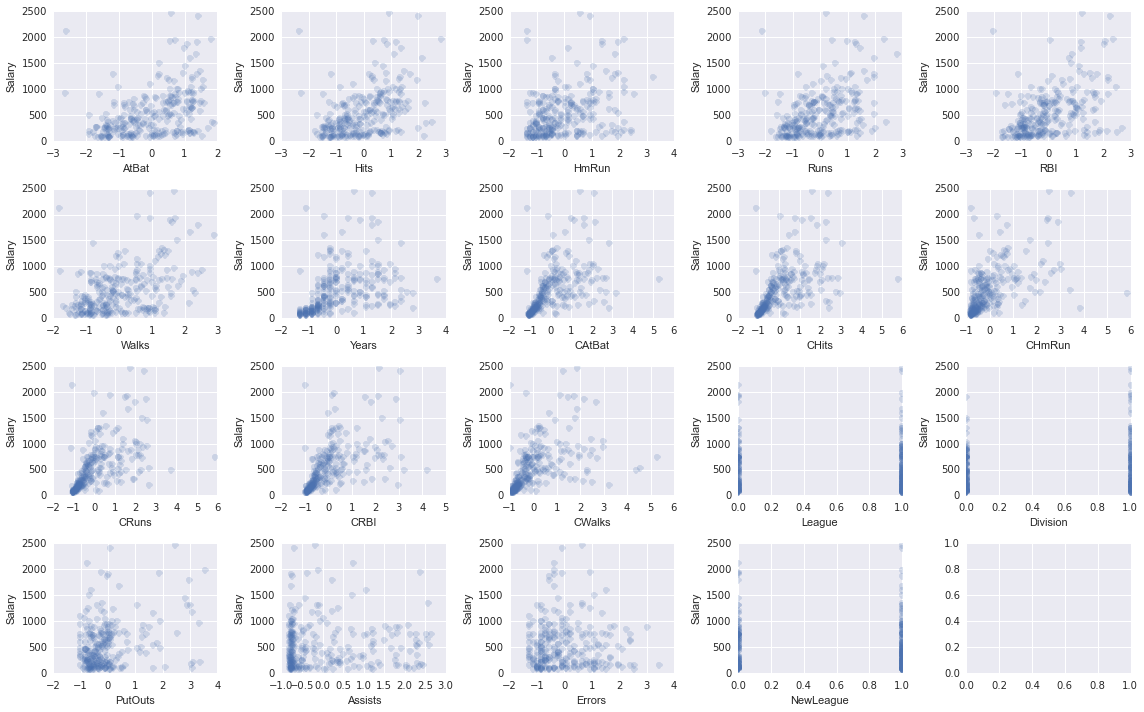

In [164]:
# 
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 10), tight_layout=True)
for ax, col in zip(axes.ravel(), ccols): #ravel: return a flatten array
    ax.plot(df[col], df.Salary, "o", alpha = 0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("Salary")

<font color = "red"> Is it necessary to transform the data using log or sqrt? It looks like some variables are non-normal distributed. </font>

## 2. Data Analysis

In [177]:
X_train = df[ccols][mask]
X_test = df[ccols][~mask]
y_train = df.Salary[mask]
y_test = df.Salary[~mask]

### Baseline Model 
Use linear regression on all the variables

In [179]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
score  = reg.score(X_test, y_test)
print score

0.25900763719


In [183]:
np.sqrt(mean_squared_error(y_pred, y_test))

330.39207801757624

### Best Selection Model

### Ridge Regression and Lasso
The correct way to do it is to split the data into training, validation and test data. Use validation set to find the best lambda, and use test set to compare different methods. Here we skip the validation step. 

<font color = "red"> Standardize needs to be done here also?</font>

In [185]:
def cross_validate(X, y, nfolds, reg_name):
    rmses = []
    kfold = KFold(X.shape[0], n_folds=nfolds)
    for train, test in kfold:
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
        reg = None
        if reg_name == "ridge":
            reg = Ridge()
        elif reg_name == "lasso":
            reg = Lasso()
        else:
            reg = LinearRegression()
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest, ypred)))
    return np.mean(rmses)


In [186]:
### need to change !!! 

X = df[ccols].values
y = df["Salary"].values
rmse_baseline = cross_validate(X, y, 10, "baseline")
rmse_ridge = cross_validate(X, y, 10, "ridge")
rmse_lasso = cross_validate(X, y, 10, "lasso")
(rmse_baseline, rmse_ridge, rmse_lasso)

/Users/lyr/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


(331.00425667935849, 328.0780249096897, 328.07275551413983)